In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
from datetime import datetime,timedelta
import re
from geopy.geocoders import Nominatim
from geopy import distance
import holidays

import warnings
warnings.filterwarnings("ignore")

In [59]:
complete_orders=pd.read_csv("../data/cleaned_complete_orders.csv")
delivery_requests=pd.read_csv("../data/driver_locations_during_request.csv")

delivery request information


In [19]:
delivery_requests.shape

(1557740, 8)

In [20]:
delivery_requests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1557740 entries, 0 to 1557739
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   id             1557740 non-null  int64  
 1   order_id       1557740 non-null  int64  
 2   driver_id      1557740 non-null  int64  
 3   driver_action  1557740 non-null  object 
 4   lat            1557740 non-null  float64
 5   lng            1557740 non-null  float64
 6   created_at     0 non-null        float64
 7   updated_at     0 non-null        float64
dtypes: float64(4), int64(3), object(1)
memory usage: 95.1+ MB


since we have no data for the `created_at` and `updated_at`, we can drop the columns as a whole

In [60]:
delivery_requests.drop(columns=["created_at","updated_at"],inplace=True)
delivery_requests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1557740 entries, 0 to 1557739
Data columns (total 6 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   id             1557740 non-null  int64  
 1   order_id       1557740 non-null  int64  
 2   driver_id      1557740 non-null  int64  
 3   driver_action  1557740 non-null  object 
 4   lat            1557740 non-null  float64
 5   lng            1557740 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 71.3+ MB


In [22]:
# there is no missing values in our dataset
delivery_requests.isna().sum()

id               0
order_id         0
driver_id        0
driver_action    0
lat              0
lng              0
dtype: int64

### Merge necessary records

In [23]:
complete_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536020 entries, 0 to 536019
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   trip_id           536020 non-null  int64  
 1   trip_origin       536020 non-null  object 
 2   trip_destination  536020 non-null  object 
 3   trip_start_time   536020 non-null  object 
 4   trip_end_time     536020 non-null  object 
 5   duration_min      536020 non-null  float64
 6   distance_km       536020 non-null  float64
 7   holiday           536020 non-null  bool   
dtypes: bool(1), float64(2), int64(1), object(4)
memory usage: 29.1+ MB


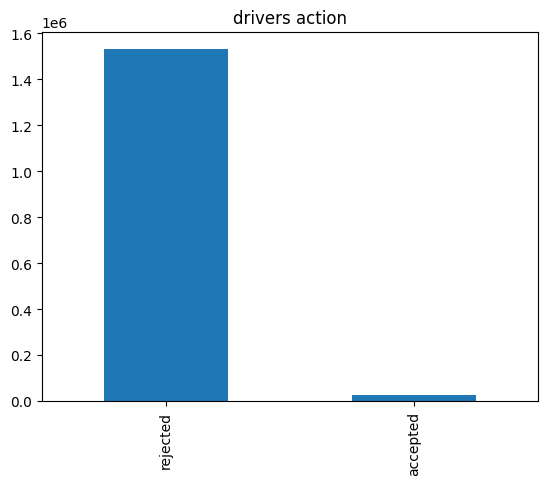

In [114]:
delivery_requests["driver_action"].value_counts().plot(kind='bar')
plt.title("drivers action")
plt.show()

### Merge assemptions

- we are going to merge the two datasets on `order_id` eqauls `trip_id`
- we already have the origin location, so we are going to take only the destination location
- only the `trip start time` has effect on drivers action, so we are going to take only the trip start time
- we take distance in km
- we take holiday status


In [64]:
useful_info = complete_orders[["trip_id","trip_origin","trip_start_time","holiday"]]

In [66]:
lat = useful_info["trip_origin"].apply(lambda x:x.split(',')[0])
lon = useful_info["trip_origin"].apply(lambda x:x.split(',')[1])
useful_info['origin_lat'],useful_info['origin_lng']=lat,lon
useful_info.rename(columns={"trip_id":"order_id"},inplace=True)
useful_info.drop(columns="trip_origin",inplace=True)

In [67]:
delivery_requests.rename(columns={"lat":"driver_lat","lng":"driver_lng"},inplace=True)

In [105]:
delivery_requests.to_csv("../data/cleaned_delivery_requests.csv",index=False)

In [69]:
merged_df=delivery_requests.merge(useful_info,on="order_id")

In [71]:
merged_df["distance_diff"]=merged_df.apply(lambda x:distance.distance((x["driver_lat"],x["driver_lng"]), (x["origin_lat"],x["origin_lng"])).km,axis=1)

In [72]:
merged_df=merged_df[["id","order_id","driver_id","driver_lat","driver_lng","origin_lat","origin_lng","distance_diff","trip_start_time","holiday","driver_action"]]

In [78]:
merged_df.distance_diff.describe()

count    1.557740e+06
mean     1.817193e+00
std      1.163014e+00
min      0.000000e+00
25%      1.105848e+00
50%      1.713717e+00
75%      2.430681e+00
max      6.560726e+02
Name: distance_diff, dtype: float64

In [86]:
accept_500=merged_df[(merged_df["distance_diff"]<=0.5) & (merged_df["driver_action"]=="accepted")].shape[0]
reject_500=merged_df[(merged_df["distance_diff"]<=0.5) & (merged_df["driver_action"]=="rejected")].shape[0]

accept_more_500=merged_df[(merged_df["distance_diff"]>0.5) & (merged_df["driver_action"]=="accepted")].shape[0]
reject_more_500=merged_df[(merged_df["distance_diff"]>0.5) & (merged_df["driver_action"]=="rejected")].shape[0]

print(f"{accept_500} requests were accepted by drivers within 500m while {reject_500} were rejected within 500m radius")
print(f"{accept_more_500} requests were accepted by drivers more than 500m while {reject_more_500} were rejected more than 500m radius")

3574 requests were accepted by drivers within 500m while 119041 were rejected within 500m radius
22329 requests were accepted by drivers more than 500m while 1412796 were rejected more than 500m radius


In [87]:
acceptance_summary=pd.DataFrame(data=[[accept_500,reject_500],[accept_more_500,reject_more_500]],columns=["accepted","rejected"],index=["with in 500m","more than 500m"])

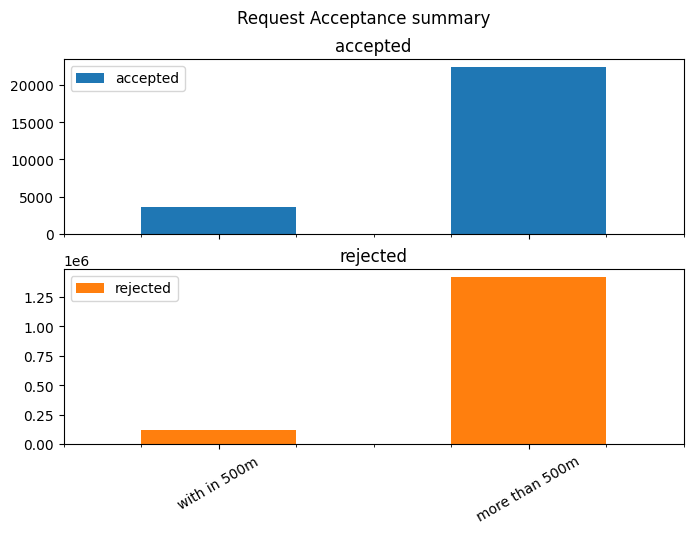

In [103]:
acceptance_summary.plot(kind='bar',subplots=True,rot=30,figsize=(8,5))
plt.suptitle("Request Acceptance summary")
plt.show()

In [107]:
merged_df.to_csv("../data/merged_df.csv",index=False)

In [108]:
# merged_df.sort_values(by="distance_diff",ascending=False)

In [109]:
# useful_info.head()

In [110]:
# delivery_requests.head()